In [2]:
import torch.nn.functional as F
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
from torch import nn
import math
from torch.optim import Adam
import tqdm
import logging
from torch import optim
import random

from functions import *

In [3]:
from IPython.display import display, HTML
from IPython.display import display
display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
dataset = torch.load('data/dataset_distlognorm_massnorm.pt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

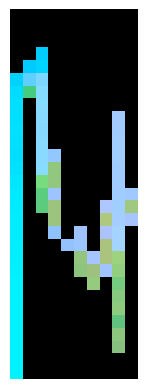

NEAREST


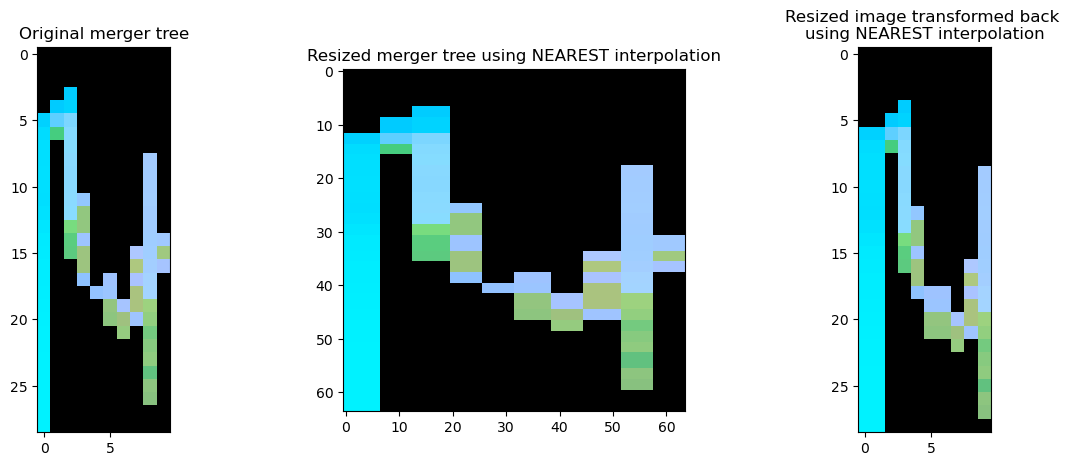

NEAREST_EXACT


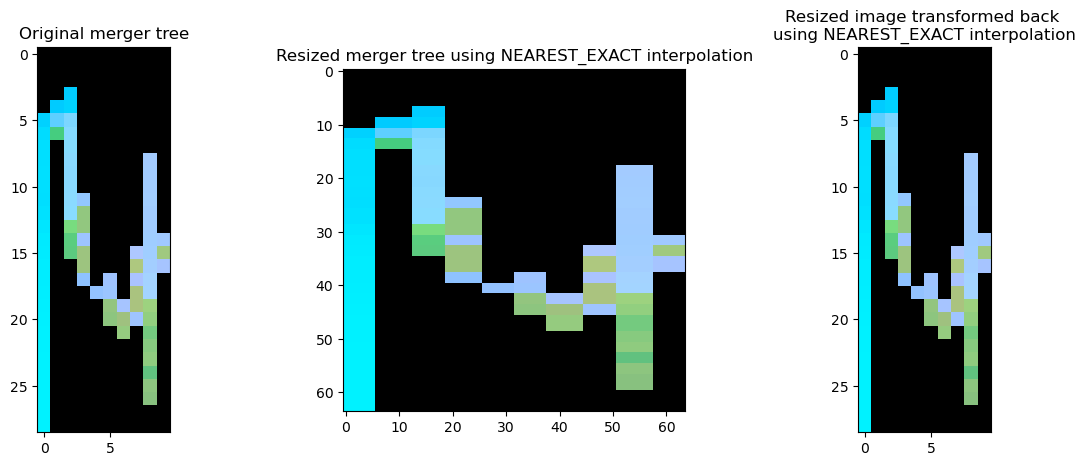

BILINEAR


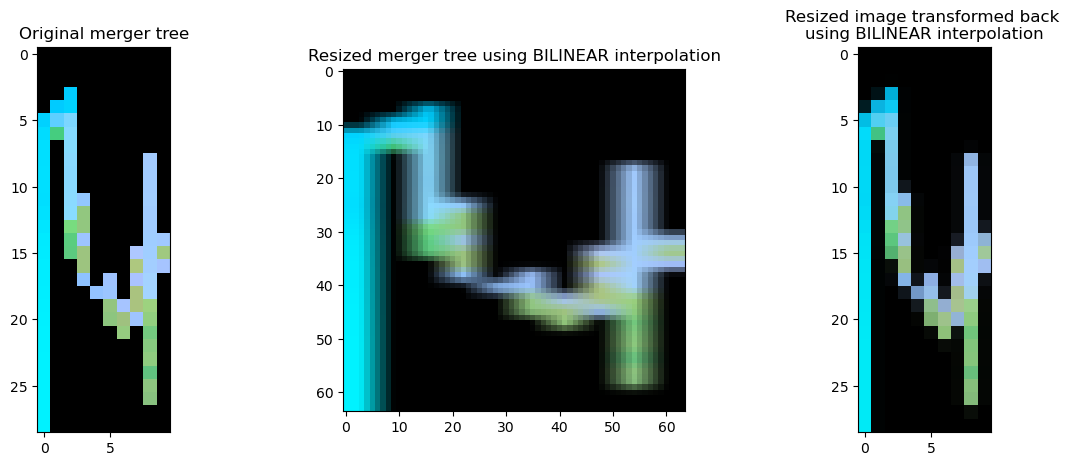

BICUBIC


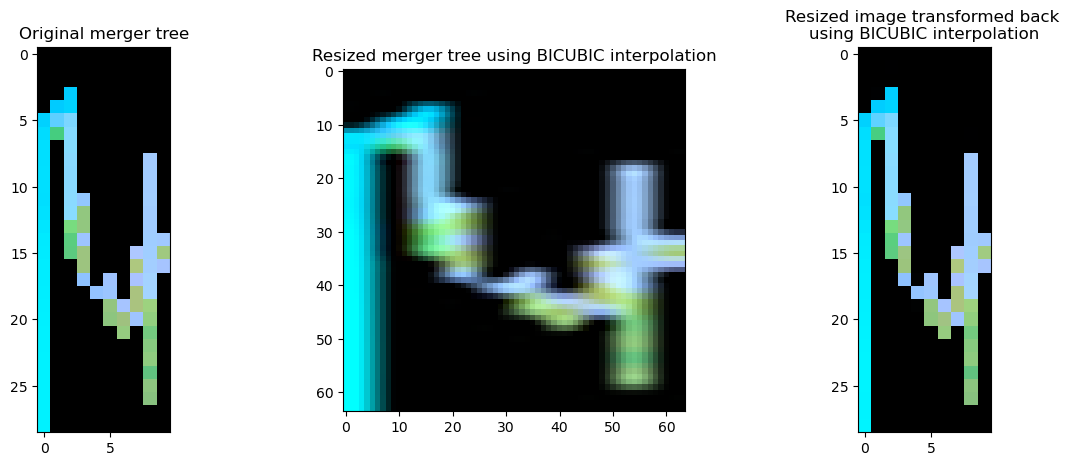

In [97]:
from torchvision import transforms


image = dataset[0]
img = image.permute(1, 2, 0).detach().numpy()
plt.imshow(img)
plt.axis('off')  # Optional: Turn off axis ticks and labels
plt.show()

interpolation_modes = [transforms.InterpolationMode.NEAREST,
                       transforms.InterpolationMode.NEAREST_EXACT,
                       transforms.InterpolationMode.BILINEAR,
                       transforms.InterpolationMode.BICUBIC]
names = ["NEAREST", "NEAREST_EXACT", "BILINEAR", "BICUBIC"]
for i, interpolationmode in enumerate(interpolation_modes):
    image = dataset[0]
    print(names[i])

    transform = transforms.Resize((64, 64), interpolation = interpolationmode)

    # Apply the transformation to the image
    resized_image = transform(image)
    img1 = resized_image.permute(1, 2, 0).detach().numpy()


    transform_back = transforms.Resize((29, 10), interpolation = interpolationmode)

    # Apply the transformation to the image
    resized_image2 = transform_back(resized_image)
    img2 = resized_image2.permute(1, 2, 0).detach().numpy()

    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Display the first image in the first subplot
    axs[0].imshow(img)
    axs[0].set_title('Original merger tree')

    axs[1].imshow(img1)
    axs[1].set_title(f"Resized merger tree using {names[i]} interpolation")

    # Display the second image in the second subplot
    axs[2].imshow(img2)
    axs[2].set_title(f"Resized image transformed back \nusing {names[i]} interpolation")
    plt.show()


In [5]:
BATCH_SIZE = 16
IMG_SIZE = 64
T = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet()
model_path = "diffusion_notebook/diffusion_2.0/diffusion_new_model2.0.pt"
saved_model = torch.load(model_path, map_location = 'cpu')
model.load_state_dict(saved_model)

<All keys matched successfully>

In [6]:
t = torch.Tensor([T])

In [7]:
diffusion = Diffusion(T)
generated_test = diffusion.sample(model, 1)

0it [00:00, ?it/s][W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
999it [16:35,  1.00it/s]


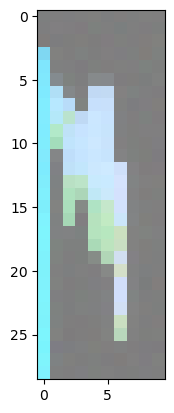

In [8]:
show_tensor_image(generated_test.detach())

In [9]:
generated_test[:, 0]

tensor([[[128, 128, 126,  ..., 128, 128, 124],
         [129, 125, 128,  ..., 127, 128, 128],
         [124, 128, 126,  ..., 127, 127, 127],
         ...,
         [129, 128, 124,  ..., 128, 125, 126],
         [127, 127, 124,  ..., 127, 127, 128],
         [127, 131, 128,  ..., 127, 128, 125]]], dtype=torch.uint8)

In [100]:
generated_test.min(), generated_test.max()

(tensor(121, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

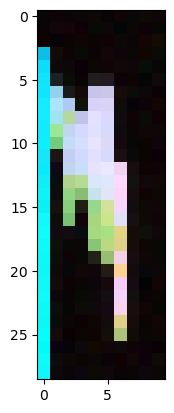

In [10]:
transform = transforms.Resize((29, 10))
generated_test_trans = transform(generated_test.to(dtype=torch.float))
generated_test_norm = normalize(generated_test_trans, True, [0, 1, 2])[0]
plt.imshow(generated_test_norm.permute(1, 2, 0))
plt.show()

In [101]:
generated_test_norm.min(),generated_test_norm.max()

(tensor(0.), tensor(1.))

- no values in dist between 0.138 and 0.448
- no values in mass between 0.17 and 0.72
- for suhalo:
    - no values between 0.18 and 0.45
    - no values between 0.64 and 0.87

# simple transform:

# check generated data

In [22]:
data1 = torch.load("diffusion_notebook/diffusion_2.0/diffusion_model2.0_images.pt", map_location = "cpu")
data2 = torch.load("diffusion_notebook/diffusion_2.0/diffusion_model2.0_images2.pt", map_location = "cpu")
data3 = torch.load("diffusion_notebook/diffusion_2.0/diffusion_model2.0_images3.pt", map_location = "cpu")
data4 = torch.load("diffusion_notebook/diffusion_2.0/diffusion_model2.0_images4.pt", map_location = "cpu")

data = torch.cat([data1, data2, data3, data4], dim = 0)
data.shape

torch.Size([40000, 3, 29, 10])

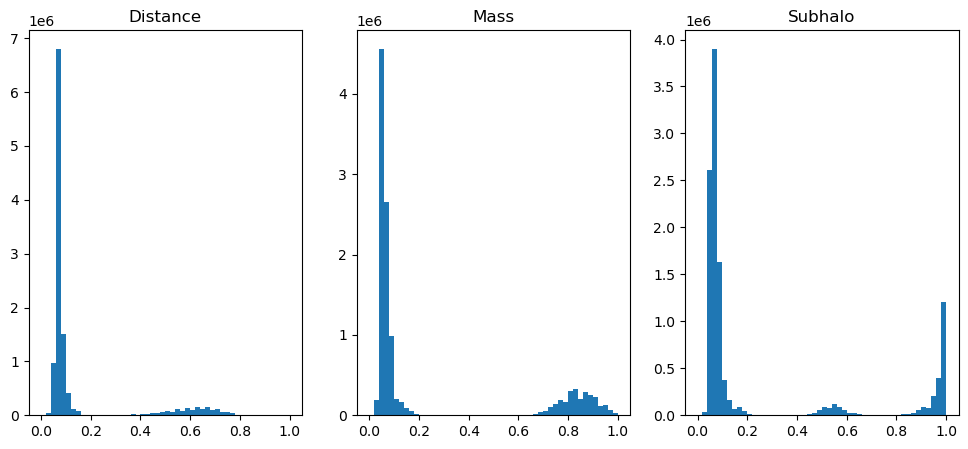

In [23]:
transform = transforms.Resize((29, 10))
data1 = transform(data.to(dtype=torch.float))
data2 = normalize(data1, True, [0, 1, 2])

dist = data2[:, 0]
mass = data2[:, 1]
subh = data2[:, 2]

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# Display the first image in the first subplot
axs[0].hist(dist.numpy().flatten(), bins = 50)
axs[0].set_title('Distance')

# Display the second image in the second subplot
axs[1].hist(mass.numpy().flatten(), bins = 50)
axs[1].set_title('Mass')

# Display the second image in the second subplot
axs[2].hist(subh.numpy().flatten(), bins = 50)
axs[2].set_title('Subhalo')

plt.show()


In [24]:
# dist
print("dist:")
lower_threshold = 0.19
upper_threshold = 0.22
count_between_thresholds = torch.sum((dist > lower_threshold) & (dist < upper_threshold)).item()
total_elements = dist.numel()
percentage_between_thresholds = (count_between_thresholds / total_elements) * 100
print(f"Percentage of values between {lower_threshold} and {upper_threshold}: {percentage_between_thresholds:.2f}%\n")

print("mass:")
lower_threshold = 0.21
upper_threshold = 0.58
count_between_thresholds = torch.sum((mass > lower_threshold) & (mass < upper_threshold)).item()
total_elements = mass.numel()
percentage_between_thresholds = (count_between_thresholds / total_elements) * 100
print(f"Percentage of values between {lower_threshold} and {upper_threshold}: {percentage_between_thresholds:.2f}%\n")

print("subh:")
lower_threshold = 0.25
upper_threshold = 0.4
count_between_thresholds = torch.sum((subh > lower_threshold) & (subh < upper_threshold)).item()
total_elements = subh.numel()
percentage_between_thresholds = (count_between_thresholds / total_elements) * 100
print(f"Percentage of values between {lower_threshold} and {upper_threshold}: {percentage_between_thresholds:.2f}%\n")
lower_threshold = 0.71
upper_threshold = 0.75
count_between_thresholds = torch.sum((subh > lower_threshold) & (subh < upper_threshold)).item()
total_elements = subh.numel()
percentage_between_thresholds = (count_between_thresholds / total_elements) * 100
print(f"Percentage of values between {lower_threshold} and {upper_threshold}: {percentage_between_thresholds:.2f}%\n")


dist:
Percentage of values between 0.19 and 0.22: 0.00%

mass:
Percentage of values between 0.21 and 0.58: 0.00%

subh:
Percentage of values between 0.25 and 0.4: 0.00%

Percentage of values between 0.71 and 0.75: 0.00%



In [25]:
data3 = transform_diffusion_image(data2, d_thresh = 0.22, m_tresh = 0.58, s_low = 0.4, s_high = 0.75)
a, b = check_consistency(data3)



Percentage of consistant images = 67.97%



Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 96.83%
inconsistency due to distance not zero in main branch =  0.00%
inconsistency due to gap between branches =  5.31%
inconsistency due to zgap in branch 5.00%
inconsistency due to last descendant dont exist 0.00%

Number of images with two or more inconsistencies = 901, which is  7.03%
That corresponds to 2.25% of all images


Of all images, 31.01% have zero inconsistency
Of all images, 0.00% have distance main branch inconsistency
Of all images, 1.70% have gap between branches inconsistency
Of all images, 1.60% have gap within branch inconsistency
Of all images, 0.00% have last descendant inconsistency


In [26]:
torch.save(a, "diffusion_notebook/diffusion_2.0/diffusion2.0_consistant_postporcessed_images_new.pt")

In [61]:
full_evaluation(data3, dataset)

Analyzing generated merger tree dataset ...

			 CONSISTENCY CHECK


Percentage of consistant images = 67.97%



Inconsistency reasons:
inconsistency due to zero / nonzero mistake = 96.83%
inconsistency due to distance not zero in main branch =  0.00%
inconsistency due to gap between branches =  5.31%
inconsistency due to zgap in branch 5.00%
inconsistency due to last descendant dont exist 0.00%

Number of images with two or more inconsistencies = 901, which is  7.03%
That corresponds to 2.25% of all images


Of all images, 31.01% have zero inconsistency
Of all images, 0.00% have distance main branch inconsistency
Of all images, 1.70% have gap between branches inconsistency
Of all images, 1.60% have gap within branch inconsistency
Of all images, 0.00% have last descendant inconsistency

			 VARIABLE CONSISTENY CHECK of consistent trees
-------------------------------------------------------------------------------------------------------
MASS:
------------------------------------------

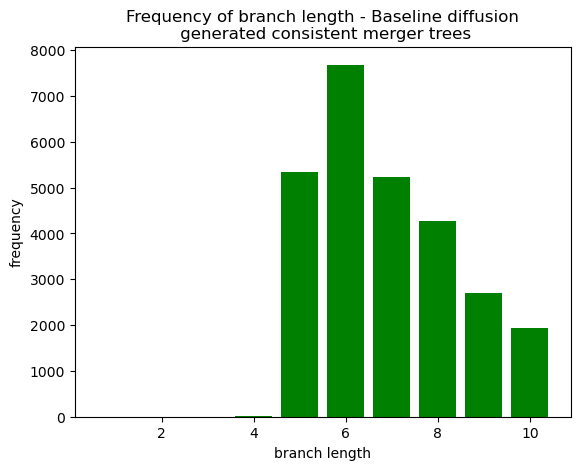

In [16]:
num_branches = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
length = [0, 0, 0, 10, 5350, 7682, 5242, 4272, 2707, 1926]

plt.bar(num_branches, length, color = "green")

# Add title and labels
plt.title('Frequency of branch length - Baseline diffusion\n generated consistent merger trees')
plt.xlabel('branch length')
plt.ylabel('frequency')
plt.savefig("test")
# Show the plot
plt.show()

Real images:


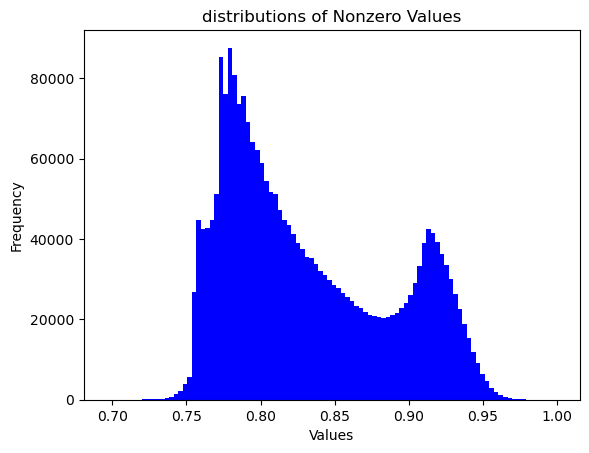

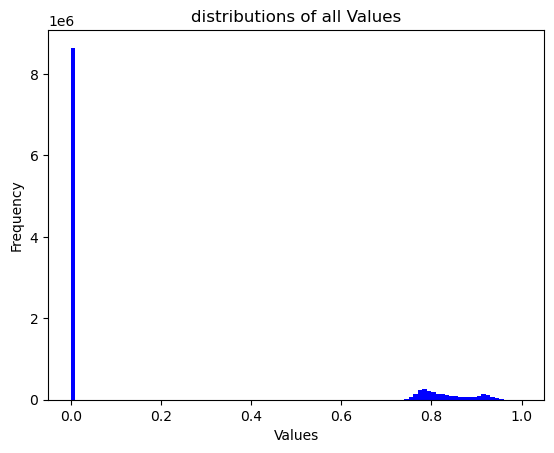

number of nonzero values = 2475374
Generated images:


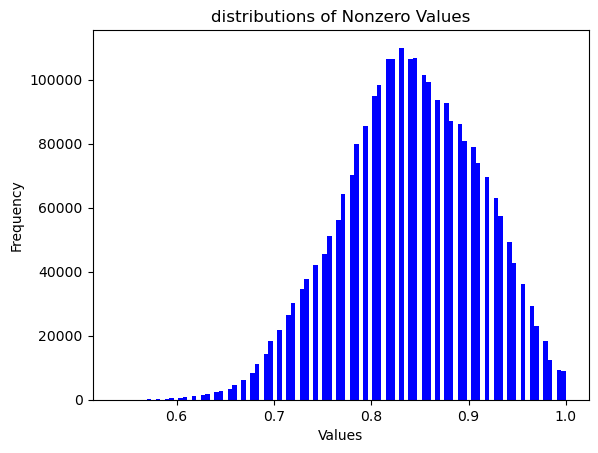

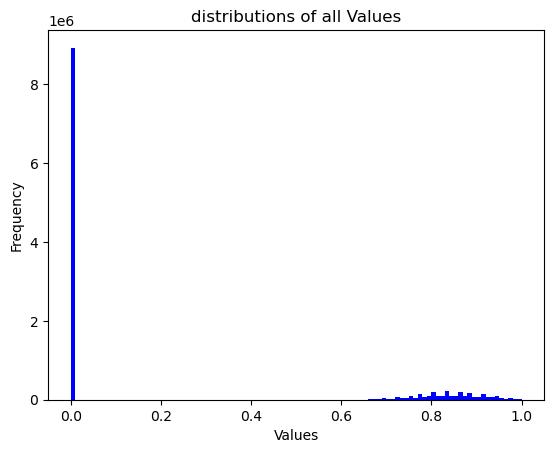

number of nonzero values = 2667194


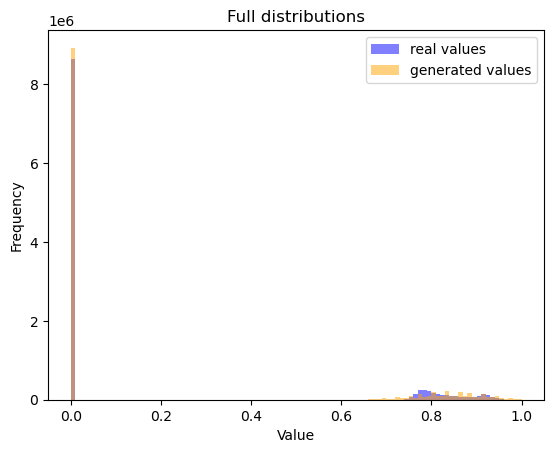

Full distribution:
KS Statistic: 0.038974372740744556
P-value: 0.0

According to regular significance level of 0.05:
The distributions are significantly different (reject H0)

According to large sample significance level of 0.05, giving significance level of 0.0006:
The distributions are significantly different (reject H0), KS statistic 0.0390 > 0.0006


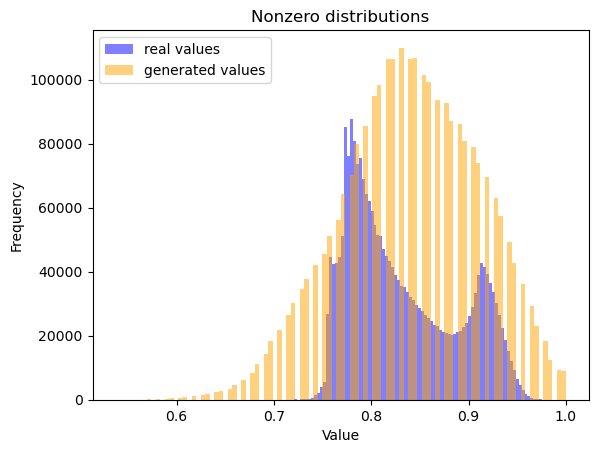

Nonzero distribution:
KS Statistic: 0.15477215048916032
P-value: 0.0

According to regular significance level of 0.05:
The distributions are significantly different (reject H0)

According to large sample significance level of 0.05, giving significance level of 0.0012:
The distributions are significantly different (reject H0), KS statistic 0.1548 > 0.0012


(0.038974372740744556, 0.15477215048916032)

In [19]:
from scipy.stats import ks_2samp
original_data = torch.load("data/dataset_distlognorm_massnorm.pt")
ks_test(original_data, data3, 1)